# $m$

In [1]:
from scipy import rand

import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict

from empir19nrm02 import _SPD, _RES

In [2]:
quantil = 0.05
dCutOff=0.003

strf1p = '$f_{1}^{´}$'
strf1pE = '$f_{1,\mathrm{E}}^{´}$'
strf1pLED = '$f_{1,\mathrm{L}}^{´}$'
strf1pMin = '$f_{1,\mathrm{Min}}^{´}$'
strf1pp = '$f_{1}^{´´}$'
strf1ppR = '$f_{1,\mathrm{R}}^{´´}$'
strf1pBW = '$f_{1,\mathrm{BW}}^{´}$'

str_q_plus_a = '$F^{a}_{i,q+}$'

strsrelLambda = '$s_{\mathrm{rel}}(\lambda)$'
strxlambda = '$\lambda$ / nm'

fig_number = 1
fig_type= '.svg'
table_type= '.csv'

label_font_size=14

#strAU = ' / A.U.'
strAU = ''
strpernm = ' / \mathrm{nm^{-1}}'

#pyplot.rcParams["figure.figsize"] = (7,7)
#pyplot.rcParams["figure.figsize"] = pyplot.rcParamsDefault["figure.figsize"]

def get_fig_file_name(filename=None, table=False):
    global fig_number
    global fig_type
    if filename is None:
        file_name = r'met2\Fig' + str(fig_number) + fig_type
        fig_number+=1
    else:
        if table:
            file_name = r'met2\Table' + filename + table_type
        else:
            file_name = r'met2\Fig' + filename + fig_type
    return file_name

def save_fig(filename=None):
    return pyplot.savefig( get_fig_file_name(filename), bbox_inches='tight', pad_inches=0)

In [3]:
# modified from luxpy vlbar

def get_target(cieobs =lx._CIEOBS, target_index = 2, scr ='dict', wl_new = None, kind ='np', out = 1):
    """
    Get target functions.

    Args:
        :cieobs:
            | str, optional
            | Sets the type of Vlambda function to obtain.
        :target_index:
            | 1, 2 or 3, optional
            |   index of the CMF to return (1...X, 2...Y, 3...Z)
        :scr:
            | 'dict' or array, optional
            | - 'dict': get from ybar from _CMF
            | - 'array': ndarray in :cieobs:
            | Determines whether to load cmfs from file (./data/cmfs/)
            | or from dict defined in .cmf.py
            | Vlambda is obtained by collecting Ybar.
        :wl:
            | None, optional
            | New wavelength range for interpolation.
            | Defaults to wavelengths specified by luxpy._WL3.
        :kind:
            | str ['np','df'], optional
            | Determines type(:returns:), np: ndarray, df: pandas.dataframe
        :out:
            | 1 or 2, optional
            |     1: returns Vlambda
            |     2: returns (Vlambda, Km)

    Returns:
        :returns:
            | dataframe or ndarray with target function of type :cieobs:


    References:
        1. `CIE15:2018, “Colorimetry,” CIE, Vienna, Austria, 2018. <https://doi.org/10.25039/TR.015.2018>`_
    """
    if scr == 'dict':
        dict_or_file = _CMF[cieobs]['bar'][[0,target_index],:]
        K = _CMF[cieobs]['K']
    elif scr == 'vltype':
        dict_or_file = cieobs #can be file or data itself
        K = 1
    Vl = lx.spd(data = dict_or_file, wl = wl_new, interpolation = 'linear', kind = kind, columns = ['wl','Vl'])

    if out == 2:
        return Vl, K
    else:
        return Vl


In [4]:
print('Version of luxpy:', lx.__version__)

_name = 'VLDetectors' # 'VLDetectors', 'XDetectors', 'YDetectors', 'ZDetectors', 'BLHDetectors','VSDetectors','SMELDetectors'
_target_name = '1931_2' # ''1931_2', BLH', 'SMEL', '1951_20_scotopic'/'VS'
_target_index = 2
S_C = 'LED_L41' # 'A'
spd = 'PHOTOLED' # 'BB, 'PHOTOLED', 'MONOLED'

str_target = ''
if _target_name == '1931_2':
    if _target_index == 1:
        str_target = '$X(\lambda)$'
    elif _target_index == 2:
        str_target = '$V(\lambda)$'
    elif _target_index == 3:
        str_target = '$Z(\lambda)$'
else:
    if _target_name == 'BLH':
        str_target = '$BLH(\lambda)$'
    if _target_name == 'VS':
        str_target = '$V^{´}(\lambda)$'
        _target_name = '1951_20_scotopic'
    if _target_name == 'SMEL':
        str_target = '$s_{\mathrm{mel}}(\lambda)$'


Version of luxpy: v1.9.6


In [5]:
_detectors=_RES[_name]['S']['data'].copy()
#display_responsivity(_name, _detectors, cieobs=_target_name, s_target_index=_target_index)

_spectra=_SPD[spd]['S']['data'].copy()
#display_spectra( _spectra)

_SMCF=np.abs(1.-lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
    _spectra, _detectors, S_C=S_C, cieobs=_target_name))

target = get_target(cieobs=_target_name, target_index=_target_index, wl_new= _detectors[0])

# Some experiments with m (CIE198-SP.1:2011, chapter 1.8)

$SMCF(T_{\mathrm{d}},T_{\mathrm{A}})=\left(\frac{T_{\mathrm{d}}}{T_{\mathrm{A}}} \right)^{m}$

Is there any connection between $f_{1}^{´}$ and m?

Generate a series of  Planckian SD with CIE standard illuminant A in the beginning

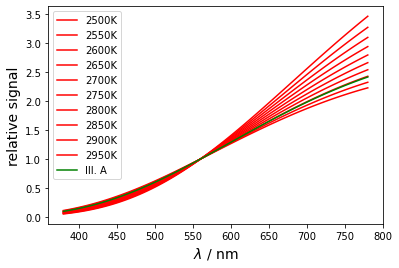

In [6]:
T_A = 2856
BB_ref = lx.spectrum.blackbody(T_A, _detectors[0], n=None, relative=True)
BB_list = BB_ref.copy()
cct_list = np.asarray(T_A)
for cct in range(2500,3000, 50):
    BB_new = lx.spectrum.blackbody(cct, _detectors[0], n=None, relative=True)
    BB_list = np.vstack((BB_list, BB_new[1]))
    cct_list = np.append(cct_list, cct)
    pyplot.plot(BB_list[0], BB_new[1], 'r-', label= str(cct) + 'K')

pyplot.plot(BB_list[0], BB_list[1], 'g-', label= 'Ill. A')
pyplot.xlabel(strxlambda, fontsize=label_font_size)
pyplot.ylabel('relative signal', fontsize=label_font_size)
pyplot.legend()

save_fig('m_SD_Lambda')


* Calculate the SMCF for all detectors and BB
* Calculate the $f_{1}^{´}$ values for the detectors

In [7]:
SMCF_BB=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
    BB_list, _detectors, S_C='A', cieobs=_target_name)

f1pA_BB=py_f1PrimeGlx(_detectors, strObserver=_target_name, iObserverOffset = _target_index-1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)

* Show the relation between $f_{1}^{´}$ and the SMCF's quantiles

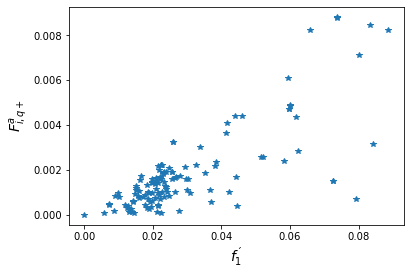

In [8]:
pyplot.plot(f1pA_BB, np.quantile(np.abs(1-SMCF_BB), 1-quantil/2, axis=0), '*')
pyplot.xlabel( strf1p, fontsize=label_font_size)
pyplot.ylabel( str_q_plus_a, fontsize=label_font_size)
save_fig('m_f1pA_absSMCF')

* Show the relation between the distribution Temperature and the SMCF's for a single detector

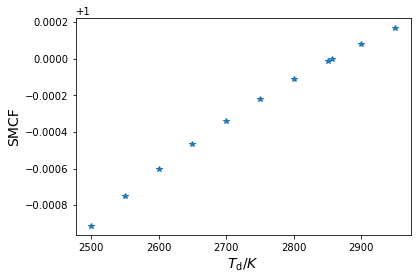

In [9]:
pyplot.plot(cct_list, SMCF_BB[:,5], '*')
pyplot.xlabel( '$T_{\mathrm{d}} / K$', fontsize=label_font_size)
pyplot.ylabel( 'SMCF', fontsize=label_font_size)
save_fig('m_SMCF_Td')

* Show the relation between $f_{1}^{´}$ and the mean m value (with 3 times std)

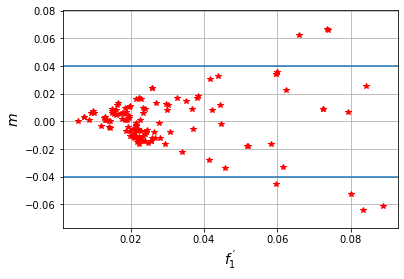

In [10]:
m = (np.log(SMCF_BB[1:,1:])).T/np.log(cct_list[1:]/T_A)
pyplot.plot(f1pA_BB[1:], np.mean(m, axis=1), 'r*')
pyplot.errorbar(f1pA_BB[1:], np.mean(m, axis=1), yerr=3*np.std(m, axis=1), fmt='None')
pyplot.grid(visible=True)
pyplot.axhline(0.04)
pyplot.axhline(-0.04)
pyplot.xlabel( strf1p, fontsize=label_font_size)
pyplot.ylabel( '$m$', fontsize=label_font_size)
save_fig('m_mmean3Std_f1pA')

* Show the relation between $f_{1}^{´}$ and the mean |m| value and the 95% quantile

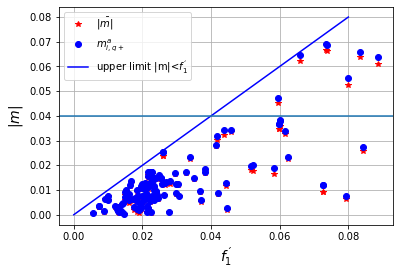

In [11]:
pyplot.plot(f1pA_BB[1:], np.mean(np.abs(m), axis=1), 'r*', label=r'$\bar{|m|}$')
pyplot.plot(f1pA_BB[1:], np.quantile(np.abs(m), 1-quantil/2, axis=1), 'bo', label=r'$m^{a}_{i,q+}$')
pyplot.plot([0, 0.08], [0, 0.08], 'b-', label=r'upper limit |m|<'+strf1p)
pyplot.grid(visible=True)
pyplot.axhline(0.04)
pyplot.xlabel( strf1p, fontsize=label_font_size)
pyplot.ylabel( '$|m|$', fontsize=label_font_size)
pyplot.legend()
save_fig('m_abs_m_quantile_f1pA')

# What about White PT-LED in this connection?

In [12]:
SMCF_PT=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
    _spectra, _detectors, S_C='LED_L41', cieobs=_target_name)

* Show the relation between $f_{1}^{´}$ and the SMCF's quantiles

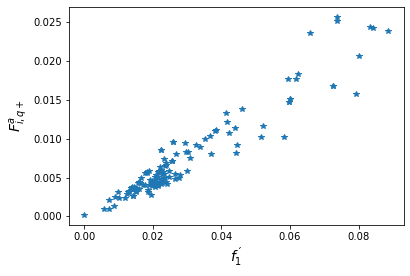

In [13]:
pyplot.plot(f1pA_BB, np.quantile(np.abs(1-SMCF_PT), 1-quantil/2, axis=0), '*')
pyplot.xlabel( strf1p, fontsize=label_font_size)
pyplot.ylabel( str_q_plus_a, fontsize=label_font_size)
save_fig('m_f1pA_absSMCF_PT')

* Show the relation between the distribution Temperature and the SMCF's for a single detector

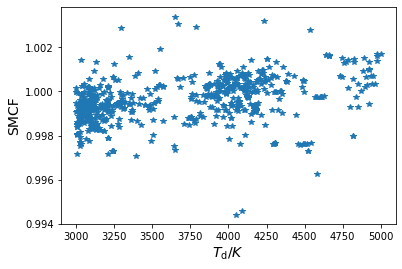

In [14]:
cct_L41 = float(lx.xyz_to_cct(lx.spd_to_xyz(_spectra[0:3]))[1])

cct_list_PT = lx.xyz_to_cct(lx.spd_to_xyz(_spectra))
valid_list = np.where( (cct_list_PT > 0) & ((cct_list_PT < 5000) & (cct_list_PT > 3000)))
cct_plot = cct_list_PT[valid_list[0]]
smcf_plot = SMCF_PT[valid_list[0],5]
pyplot.plot(cct_list_PT[valid_list], SMCF_PT[valid_list[0],5], '*')
pyplot.xlabel( '$T_{\mathrm{d}} / K$', fontsize=label_font_size)
pyplot.ylabel( 'SMCF', fontsize=label_font_size)
save_fig('m_SMCF_Td_PT')

* Show the relation between $f_{1}^{´}$ and the mean m value (with 3 times std)

<ipython-input-15-b23827b8cbb7>:1: RuntimeWarning: divide by zero encountered in true_divide
  m = (np.log(SMCF_PT[valid_list[0],1:])).T/np.log(np.squeeze(cct_list_PT[valid_list[0]]/cct_L41))


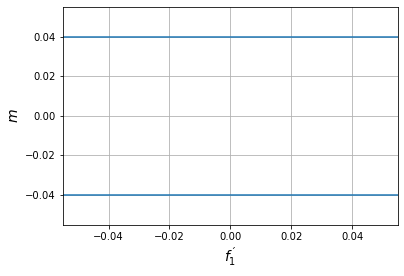

In [15]:
m = (np.log(SMCF_PT[valid_list[0],1:])).T/np.log(np.squeeze(cct_list_PT[valid_list[0]]/cct_L41))
pyplot.plot(f1pA_BB[1:], np.mean(m, axis=1), 'r*')
#pyplot.errorbar(f1pA_BB[1:], np.mean(m, axis=1), yerr=3*np.std(m, axis=1), fmt='None')
pyplot.grid(visible=True)
pyplot.axhline(0.04)
pyplot.axhline(-0.04)
pyplot.xlabel( strf1p, fontsize=label_font_size)
pyplot.ylabel( '$m$', fontsize=label_font_size)
save_fig('m_mmean3Std_f1pA_PT')

* This type of model is not applicable :-( here